<a href="https://colab.research.google.com/github/melyneca/shipstuff/blob/main/shipship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Önce uygun kütüphaneler yüklenir


In [ ]:
import torch
import pandas as pd
import torchvision
import numpy as np

Zip dosyası açılır ve extractall() ile dosyalar dışarı çıkarılır

In [108]:
from zipfile import ZipFile
  
# Zip file directory
file_name = "/content/archive (1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # extracting all the files
    zip.extractall()

GPU kullanılabilir durumdayda GPU kullanılır, değilde CPU kullanılır

In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Zip içindeki resimler dataset haline getirilir

In [107]:
import os
from torch.utils.data import Dataset
from skimage import io

class ShipLoad(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    #Returns the lenght of the dataset
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    
    y_label = torch.tensor(int(self.annotations.iloc[index, 1])-1)

    #Applies the transformation
    if self.transform:
      image = self.transform(image)

    return (image, y_label)

Modelin öğrenebilmesi için resimlerin belli bir yapıda olması gerekir. Bu yüzden uygun transform fonksiyonları uygulanır
Dataset içinde siyah-beyaz resimler de bulunduğu için, tüm resimleri siyah-beyaz bir şekilde işlemek daha verimli oldu

In [209]:
import torchvision.transforms as transforms

transform= transforms.Compose([
        transforms.ToPILImage(),
        #The dataset contains grayscaled images. 
        #Making all the images grayscaled works better
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(degrees=(-10,+10),translate=(0,0.15), scale=(0.9,1.1)),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        #The images should be normalized, If not the calculations can not be made 
        transforms.Normalize((0.5),(0.2))
        ])

Elimde bulunan veri setinde sadece train set sınıflandırılmıştı. Doğru bir şekilde modeli test etmek için tüm sınıflandırılmış resimleri %80-%20 şeklinde böldüm

In [210]:
from torch.utils.data import random_split

#Loads all labeled images, and splits it to test and train data
data = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)
train_set_size = int(len(data) * 0.9)
test_set_size = len(data) - train_set_size
train_set, test_set = random_split(data, [train_set_size, test_set_size])

In [211]:
print(f"Total data: {len(data)}")
print(f"Size of train data: {len(train_set)}")
print(f"Size of test data: {len(test_set)}")
image,label = train_set[8]
print(f"Shape of one image: {image.shape}")
print(f"Number of color channel: {image.shape[0]}")
print(f"Widht and Height: ({image.shape[1]},{image.shape[2]})")

Total data: 6252
Size of train data: 5626
Size of test data: 626
Shape of one image: torch.Size([1, 128, 128])
Number of color channel: 1
Widht and Height: (128,128)


In [212]:
classes = ['Cargo','Military','Carrier','Cruise','Tankers']
print(f"Class of ships: {classes}")

Class of ships: ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']


#Transformasyon uygulanmadan önceki gemi fotoğrafları

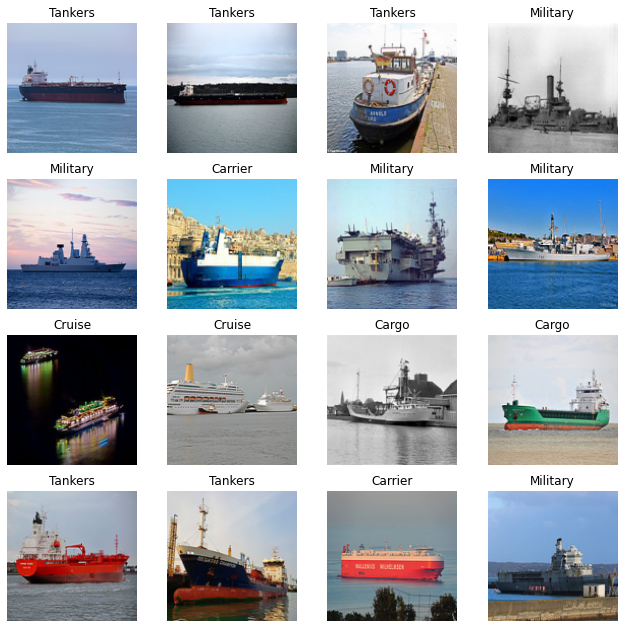

Data augmentation az sayıda olan veri sayısını arttırmak için kullanılır. Öğrenme sürecinde daha iyi bir doğruluk oranına çıkması sağlanır. Random Affine fonksiyonu bunu yapabilmemizi sağlar. Normalization ise train yapılırken hesaplamanın yapılabilmesi için gereklidir.

#Transformasyondan sonra oluşan fotoğraflar

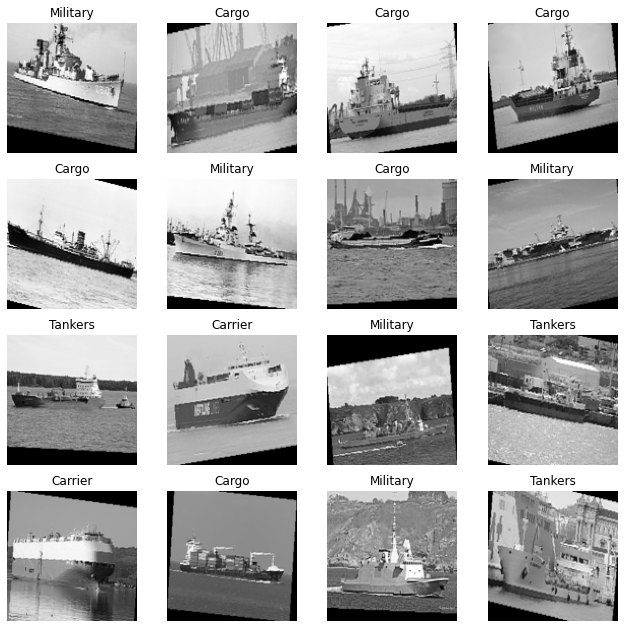

In [213]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(11,11))

#Prints random images from dataset
for i in range(1,17):
  id = random.randint(0,len(train_set))
  images, label = train_set[id] 
  fig.add_subplot(4, 4, i)
  plt.imshow(images.squeeze(), cmap="gray")
  plt.axis('off');
  plt.title(classes[label]);

DataLoadder kullanılarak resimler batchler halinde yüklenir. Model her bir epochta 32 adet resim görür.


In [238]:
from torch.utils.data import DataLoader

train_data = DataLoader(dataset = train_set, batch_size= 16, shuffle= True)
# The model have never seen the test images before. No need to shuffle
test_data = DataLoader(dataset = test_set, batch_size= 16, shuffle= False)

In [239]:
from torch.nn.modules.activation import Softmax
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, output_shape: int):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=16, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, 
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, 
                      out_channels=16,
                      kernel_size=2,
                      stride=2,
                      padding=0),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, 
                      out_channels=32, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,
                      out_channels=32, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, 
                      out_channels=32,
                      kernel_size=2,
                      stride=2,
                      padding=0),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, 
                      out_channels=64, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64,
                      out_channels=64, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, 
                      out_channels=64,
                      kernel_size=2,
                      stride=2,
                      padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(64*16*16), 
                      out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),          
            nn.Linear(in_features=1024, 
                      out_features=output_shape),
            nn.Softmax(dim = 1)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv3(self.conv2(self.conv1(x)))
        x = self.classifier(x)
        return x


In [240]:
modelCNN = CNN(output_shape=5).to(device)

In [241]:
print(f"Model:\n{modelCNN}")

Model:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [242]:
load = False
if load:
  save = torch.load("model5.pt")

In [243]:
save = {
    "test_loss" : [],
    "test_acc" : [],
    "train_loss" : [],
    "train_acc" : [],
    "model" : {}
}

In [244]:
def accuracy_func(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred))
    return acc

In [245]:
def test_model(model: torch.nn.Module,
               data: torch.utils.data.DataLoader,
               device: torch.device,
               loss_func: torch.nn.Module,
               accuracy_func
               ):
  loss_test = 0
  acc_test = 0

  #Puts the model into evatuation mode
  model.eval()
  #Does not calculate the 
  with torch.inference_mode():
    for image_test, label_test in data:
          
      image_test = image_test.to(device)
      label_test = label_test.type(torch.long).to(device)
      

      label_pred = model(image_test)
      
      loss_test += loss_func(label_pred, label_test)
      
      acc_test += accuracy_func(y_true=label_test, y_pred=label_pred.argmax(dim=1))
      
      # Scale loss and acc
    loss_test = loss_test/len(data)
    acc_test = acc_test*100/len(data)

  return{"loss": loss_test.item(),
         "accuracy": acc_test}

In [246]:
#Trains the model
def train_model(model: torch.nn.Module,
                data: torch.utils.data.DataLoader,
                device: torch.device,
                optimizer: torch.optim.Optimizer,
                loss_func: torch.nn.Module,
                accuracy_func):
  loss_train = 0
  acc_train = 0

  for batch, (image, label) in enumerate(data):  
    model.train() 
    image = image.to(device)
    label = label.type(torch.long).to(device)
         
    # Forward pass
    label_pred = model(image)

    # Calculate loss 
    loss = loss_func(label_pred, label)
    loss_train += loss
    acc_train += accuracy_func(y_true=label, y_pred= label_pred.argmax(dim=1)) 

    # Backward
    optimizer.zero_grad()
    loss.backward()

    # Optimizer
    optimizer.step()

  loss_train = loss_train/len(data)
  acc_train = acc_train*100/len(data)

  #Returns the loss and accuracy of the trainig model
  return{"loss": loss_train.item(),
         "accuracy": acc_train}
  

In [247]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelCNN.parameters(), lr=0.01)
#Every 30 epoch, multiplies the learning rate with 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

In [249]:
epochs = 121

In [251]:
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-------")
  
  # Trains the model
  train_result = train_model(model = modelCNN,
                             data = train_data,
                             device = device,
                             optimizer = optimizer,
                             loss_func = loss_func,
                             accuracy_func = accuracy_func)
  
  #Updates the learning rate
  scheduler.step()

  save["train_acc"].append(train_result["accuracy"])
  save["train_loss"].append(train_result["loss"])

  test_result =  test_model(model = modelCNN,
                          data = test_data,
                          device = device,
                          loss_func = loss_func,
                          accuracy_func = accuracy_func)
    
  save["test_acc"].append(test_result["accuracy"])
  save["test_loss"].append(test_result["loss"])

  #Every 5 epoch saves the model and test results
  if epoch%5 == 0:
    save["model"] = modelCNN.state_dict
    torch.save(save,"model" + str(epoch) + ".pt")
    
    acc = train_result["accuracy"]
    loss = train_result["loss"]
    print(f"Train acc:{acc}")
    print(f"Train loss:{loss}")

    acc_test = test_result["accuracy"]
    loss_test = test_result["loss"]
    print(f"Test acc:{acc_test}")
    print(f"Test acc:{loss_test}")



Epoch: 0
-------
Train acc:83.28835227272727
Train loss:1.0785385370254517
Test acc:77.34375
Test acc:1.12466561794281
Epoch: 1
-------
Epoch: 2
-------
Epoch: 3
-------
Epoch: 4
-------
Epoch: 5
-------
Train acc:82.96164772727272
Train loss:1.0785287618637085
Test acc:77.96875
Test acc:1.1219791173934937
Epoch: 6
-------
Epoch: 7
-------
Epoch: 8
-------
Epoch: 9
-------
Epoch: 10
-------
Train acc:83.29900568181817
Train loss:1.076440453529358
Test acc:78.90625
Test acc:1.1180614233016968
Epoch: 11
-------
Epoch: 12
-------
Epoch: 13
-------
Epoch: 14
-------
Epoch: 15
-------
Train acc:82.79119318181819
Train loss:1.0805400609970093
Test acc:78.90625
Test acc:1.124732494354248
Epoch: 16
-------
Epoch: 17
-------
Epoch: 18
-------
Epoch: 19
-------
Epoch: 20
-------
Train acc:82.6846590909091
Train loss:1.0842105150222778
Test acc:78.75
Test acc:1.1201575994491577
Epoch: 21
-------
Epoch: 22
-------
Epoch: 23
-------
Epoch: 24
-------
Epoch: 25
-------
Train acc:82.64914772727273
Tr

KeyboardInterrupt: ignored

In [ ]:
def ModelResult(im = torch.tensor(),
                model= torch.nn.Module,
                ):
  pred = model(im)
  return pred

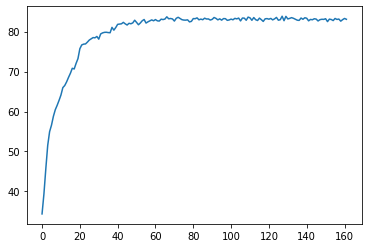

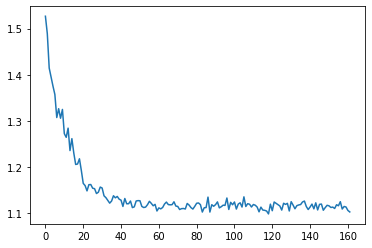

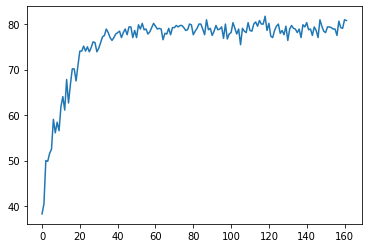

In [252]:

plt.plot(range(len(save["train_acc"])),save["train_acc"])
plt.show()
plt.plot(range(len(save["test_loss"])),save["test_loss"])
plt.show()
plt.plot(range(len(save["test_acc"])),save["test_acc"])
plt.show()